当前使用的设备: mps


Epoch 1/20: 100%|█████████████████████████████| 400/400 [00:04<00:00, 89.56it/s]


Epoch 1/20 | Train Loss: 2.4198 | Val Loss: 1.6702 | Val Acc: 0.4594 | Val F1: 0.3944
 Val Loss 下降，保存当前模型到 attention_bilstm_relation_extractor.pt


Epoch 2/20: 100%|█████████████████████████████| 400/400 [00:04<00:00, 87.98it/s]


Epoch 2/20 | Train Loss: 1.5730 | Val Loss: 1.2476 | Val Acc: 0.6056 | Val F1: 0.5977
 Val Loss 下降，保存当前模型到 attention_bilstm_relation_extractor.pt


Epoch 3/20: 100%|█████████████████████████████| 400/400 [00:04<00:00, 92.82it/s]


Epoch 3/20 | Train Loss: 1.2007 | Val Loss: 1.0649 | Val Acc: 0.6606 | Val F1: 0.6535
 Val Loss 下降，保存当前模型到 attention_bilstm_relation_extractor.pt


Epoch 4/20: 100%|█████████████████████████████| 400/400 [00:04<00:00, 91.77it/s]


Epoch 4/20 | Train Loss: 0.9297 | Val Loss: 1.0549 | Val Acc: 0.6631 | Val F1: 0.6517
 Val Loss 下降，保存当前模型到 attention_bilstm_relation_extractor.pt


Epoch 5/20: 100%|█████████████████████████████| 400/400 [00:04<00:00, 91.24it/s]


Epoch 5/20 | Train Loss: 0.6973 | Val Loss: 1.0438 | Val Acc: 0.6737 | Val F1: 0.6812
 Val Loss 下降，保存当前模型到 attention_bilstm_relation_extractor.pt


Epoch 6/20: 100%|█████████████████████████████| 400/400 [00:04<00:00, 92.93it/s]


Epoch 6/20 | Train Loss: 0.4931 | Val Loss: 1.0624 | Val Acc: 0.6819 | Val F1: 0.6885


Epoch 7/20: 100%|█████████████████████████████| 400/400 [00:04<00:00, 91.58it/s]


Epoch 7/20 | Train Loss: 0.3291 | Val Loss: 1.0846 | Val Acc: 0.6919 | Val F1: 0.6883


Epoch 8/20: 100%|█████████████████████████████| 400/400 [00:04<00:00, 92.44it/s]


Epoch 8/20 | Train Loss: 0.2498 | Val Loss: 1.1003 | Val Acc: 0.6831 | Val F1: 0.6838


Epoch 9/20: 100%|█████████████████████████████| 400/400 [00:04<00:00, 91.95it/s]


Epoch 9/20 | Train Loss: 0.1739 | Val Loss: 1.2471 | Val Acc: 0.6675 | Val F1: 0.6740


Epoch 10/20: 100%|████████████████████████████| 400/400 [00:04<00:00, 90.78it/s]


Epoch 10/20 | Train Loss: 0.1247 | Val Loss: 1.1776 | Val Acc: 0.6887 | Val F1: 0.6921
 验证集Loss连续多次未提升，提前停止训练。


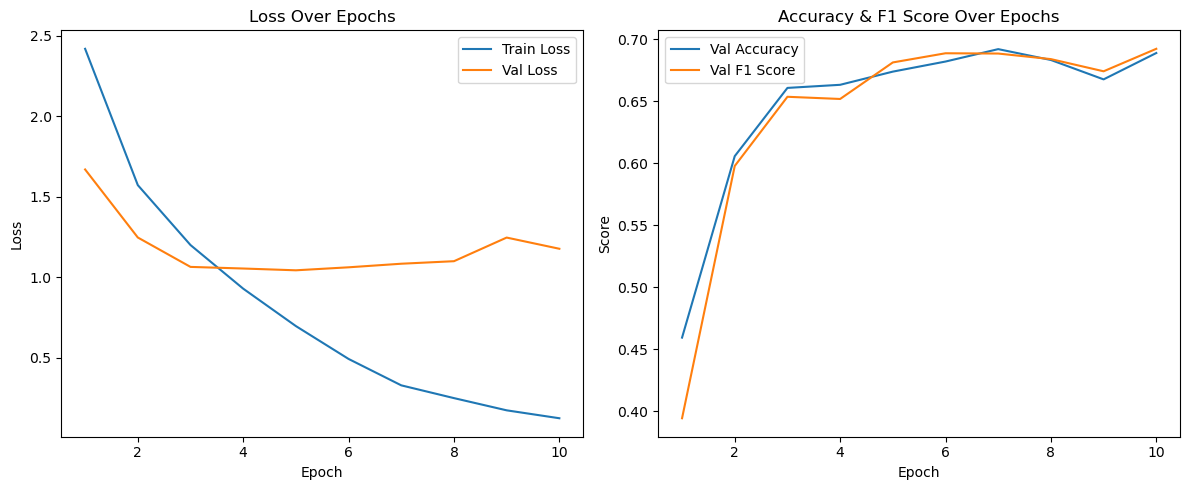

 模型已成功加载并准备使用


/var/folders/g7/xh9qh0js6qvg0d5lb8c7n3lc0000gn/T/ipykernel_56020/3610386886.py:229: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('attention

In [36]:
!pip install datasets

# 导入库
from datasets import load_dataset
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
from tqdm import tqdm
import matplotlib.pyplot as plt
import re
from nltk.tokenize import word_tokenize
from gensim.models import KeyedVectors

# 1. 数据预处理
class SemEvalDataset(Dataset):
    def __init__(self, sentences, labels, word2idx, max_len=100):
        self.sentences = sentences
        self.labels = labels
        self.word2idx = word2idx
        self.max_len = max_len

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        tokens = word_tokenize(self.sentences[idx].lower())
        seq = [self.word2idx.get(token, self.word2idx['<UNK>']) for token in tokens]
        if len(seq) < self.max_len:
            seq += [self.word2idx['<PAD>']] * (self.max_len - len(seq))
        else:
            seq = seq[:self.max_len]
        return torch.tensor(seq), torch.tensor(self.labels[idx])

# 2. 加载GloVe词向量
def load_glove_embeddings(glove_file, word2idx, embedding_dim=300):
    embeddings = np.random.uniform(-0.25, 0.25, (len(word2idx), embedding_dim))
    embeddings[word2idx['<PAD>']] = np.zeros(embedding_dim)
    with open(glove_file, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            if word in word2idx:
                vector = np.asarray(values[1:], dtype='float32')
                embeddings[word2idx[word]] = vector
    return torch.tensor(embeddings, dtype=torch.float)

# 3. Attention 机制
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super(Attention, self).__init__()
        self.attention = nn.Linear(hidden_dim * 2, 1)

    def forward(self, lstm_out):
        weights = torch.softmax(self.attention(lstm_out), dim=1)
        context = torch.sum(weights * lstm_out, dim=1)
        return context

# 4. BiLSTM模型
class BiLSTMRelationExtractor(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embeddings):
        super(BiLSTMRelationExtractor, self).__init__()
        # 载入预训练Embedding（可训练）
        self.embedding = nn.Embedding.from_pretrained(embeddings, freeze=False)

        # 新增：Embedding层后再加一个Dropout
        self.embedding_dropout = nn.Dropout(0.5)

        # 如果num_layers=1，LSTM自带的dropout不会生效，因此后面我们手动加Dropout
        self.bilstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=1, 
                              bidirectional=True, batch_first=True)

        self.attention = Attention(hidden_dim)
        self.dropout = nn.Dropout(0.5)  # 用于对LSTM输出、Attention输出做dropout
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        # x: (batch_size, seq_len)
        x = self.embedding(x)           # (batch_size, seq_len, embedding_dim)
        x = self.embedding_dropout(x)   # 对embedding结果做Dropout

        lstm_out, _ = self.bilstm(x)    # (batch_size, seq_len, 2*hidden_dim)
        lstm_out = self.dropout(lstm_out)  # 对LSTM输出再做Dropout

        context = self.attention(lstm_out) # (batch_size, 2*hidden_dim)
        context = self.dropout(context)    # 对Attention结果做Dropout

        out = self.fc(context)             # (batch_size, output_dim)
        return out

# 5. 训练与评估 (加入 Early Stopping)
def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10, patience=3):
    train_losses = []
    val_losses = []
    val_accuracies = []
    val_f1_scores = []

    # Early Stopping 变量
    best_val_loss = float('inf')
    no_improve_count = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # 验证集评估
        model.eval()
        y_true, y_pred = [], []
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                y_true.extend(y_batch.tolist())
                y_pred.extend(predicted.tolist())

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        acc = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average='weighted')
        val_accuracies.append(acc)
        val_f1_scores.append(f1)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | "
              f"Val Acc: {acc:.4f} | "
              f"Val F1: {f1:.4f}")

        # ---------- Early Stopping 检查 ----------
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            no_improve_count = 0
            torch.save(model.state_dict(), 'attention_bilstm_relation_extractor.pt')
            print(" Val Loss 下降，保存当前模型到 attention_bilstm_relation_extractor.pt")
        else:
            no_improve_count += 1
            if no_improve_count >= patience:
                print(" 验证集Loss连续多次未提升，提前停止训练。")
                break

    # 绘制训练曲线
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(range(1, len(train_losses)+1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses)+1), val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Over Epochs')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(range(1, len(val_accuracies)+1), val_accuracies, label='Val Accuracy')
    plt.plot(range(1, len(val_f1_scores)+1), val_f1_scores, label='Val F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.title('Accuracy & F1 Score Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

# 6. 主程序
if __name__ == '__main__':
    # 设备选择：优先使用 MPS (Metal) 或 CPU
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    print(f"当前使用的设备: {device}")

    # 加载数据集（如 "SemEvalWorkshop/sem_eval_2010_task_8" 或其他）
    dataset = load_dataset("SemEvalWorkshop/sem_eval_2010_task_8")
    full_train = dataset['train']
    sentences = full_train['sentence']
    labels = full_train['relation']

    # 词表构建
    all_tokens = [word_tokenize(s.lower()) for s in sentences]
    vocab = {word for tokens in all_tokens for word in tokens}
    word2idx = {word: idx + 2 for idx, word in enumerate(vocab)}
    word2idx['<PAD>'] = 0
    word2idx['<UNK>'] = 1

    # 加载GloVe
    embedding_dim = 300
    glove_path = 'glove.6B.300d.txt'  # 确保已下载或存在当前工作目录
    embeddings = load_glove_embeddings(glove_path, word2idx, embedding_dim)

    # 数据集与DataLoader
    X_train, X_val, y_train, y_val = train_test_split(sentences, labels, test_size=0.2, random_state=42)
    train_dataset = SemEvalDataset(X_train, y_train, word2idx)
    val_dataset = SemEvalDataset(X_val, y_val, word2idx)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

    # 初始化模型
    hidden_dim = 64
    # 此处SemEval-2010 Task 8 一般有19类关系，如有需要自行检查
    output_dim = 19  
    model = BiLSTMRelationExtractor(len(word2idx), embedding_dim, hidden_dim, output_dim, embeddings)
    model = model.to(device)

    # 使用带 weight_decay 的Adam做L2正则化
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

    # 训练模型(20个epoch，可被Early Stopping提前终止)
    train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=20, patience=5)

    # 加载早停前保存的最佳模型
    model.load_state_dict(torch.load('attention_bilstm_relation_extractor.pt', map_location=device))
    model.eval()
    print(" 模型已成功加载并准备使用")

 Test Loss: 1.0207
 Test Accuracy: 0.6721
 Test F1 Score: 0.6759

 Classification Report:
                            precision    recall  f1-score   support

      Cause-Effect(e1,e2)       0.93      0.81      0.87       134
      Cause-Effect(e2,e1)       0.89      0.87      0.88       194
 Instrument-Agency(e1,e2)       0.80      0.72      0.76       162
 Instrument-Agency(e2,e1)       0.63      0.61      0.62       150
  Product-Producer(e1,e2)       0.83      0.82      0.83       153
  Product-Producer(e2,e1)       0.90      0.72      0.80        39
 Content-Container(e1,e2)       0.79      0.87      0.83       291
 Content-Container(e2,e1)       0.00      0.00      0.00         1
     Entity-Origin(e1,e2)       0.77      0.82      0.79       211
     Entity-Origin(e2,e1)       0.94      0.62      0.74        47
Entity-Destination(e1,e2)       0.25      0.05      0.08        22
Entity-Destination(e2,e1)       0.58      0.55      0.57       134
   Component-Whole(e1,e2)       0.83 

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


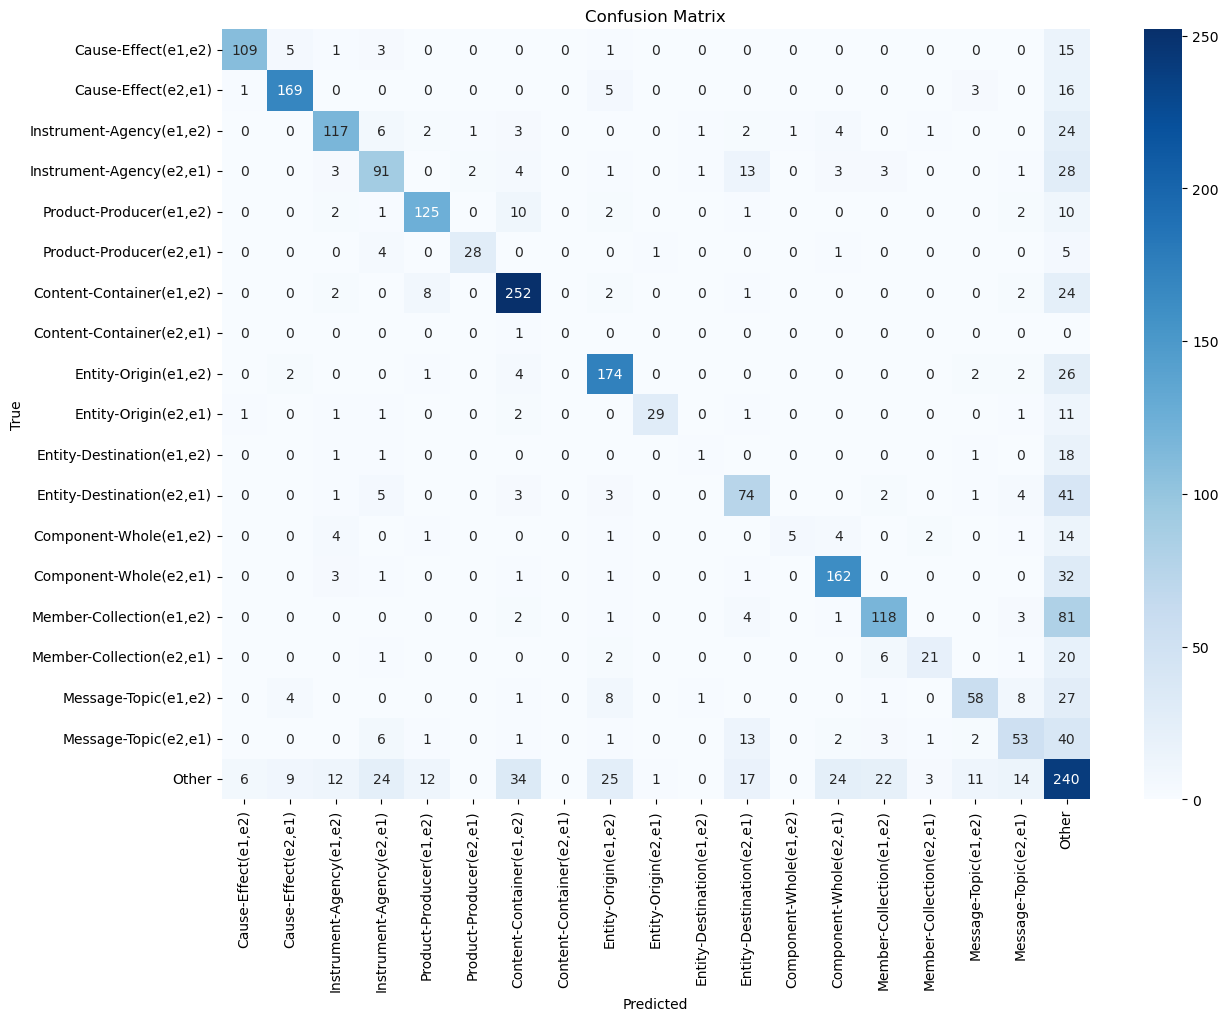

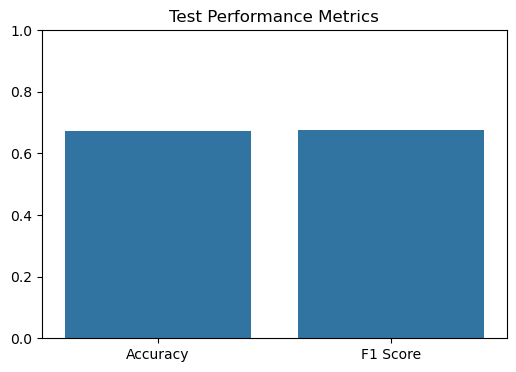

In [37]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def evaluate_on_test_set(model, test_loader, criterion, device, label_names):
    model.eval()
    y_true, y_pred = [], []
    test_loss = 0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            y_true.extend(y_batch.cpu().tolist())
            y_pred.extend(predicted.cpu().tolist())

    #  计算结果
    avg_test_loss = test_loss / len(test_loader)
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f" Test Loss: {avg_test_loss:.4f}")
    print(f" Test Accuracy: {accuracy:.4f}")
    print(f" Test F1 Score: {f1:.4f}")
    print("\n Classification Report:\n", classification_report(y_true, y_pred, target_names=label_names))

    #  混淆矩阵
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(14, 10))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_names, yticklabels=label_names, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    #  准确率 & F1 Score 可视化
    metrics = ['Accuracy', 'F1 Score']
    scores = [accuracy, f1]

    plt.figure(figsize=(6, 4))
    sns.barplot(x=metrics, y=scores)
    plt.ylim(0, 1)
    plt.title('Test Performance Metrics')
    plt.show()



model.load_state_dict(torch.load('attention_bilstm_relation_extractor.pt', map_location=device, weights_only=True))
model.eval()

# 测试数据
test_sentences = dataset['test']['sentence']
test_labels = dataset['test']['relation']

# 词表映射
all_tokens = [word_tokenize(s.lower()) for s in test_sentences]
test_dataset = SemEvalDataset(test_sentences, test_labels, word2idx)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# 损失函数
criterion = nn.CrossEntropyLoss()

#  完整的 19 个类别标签
label_names = [
    "Cause-Effect(e1,e2)", "Cause-Effect(e2,e1)", 
    "Instrument-Agency(e1,e2)", "Instrument-Agency(e2,e1)", 
    "Product-Producer(e1,e2)", "Product-Producer(e2,e1)", 
    "Content-Container(e1,e2)", "Content-Container(e2,e1)", 
    "Entity-Origin(e1,e2)", "Entity-Origin(e2,e1)", 
    "Entity-Destination(e1,e2)", "Entity-Destination(e2,e1)", 
    "Component-Whole(e1,e2)", "Component-Whole(e2,e1)", 
    "Member-Collection(e1,e2)", "Member-Collection(e2,e1)", 
    "Message-Topic(e1,e2)", "Message-Topic(e2,e1)", 
    "Other"
]

#  执行测试
evaluate_on_test_set(model, test_loader, criterion, device, label_names)